# 09 Case Study

0. Introduction
1. Selecting Topics
    1. Choosing four Topics
    2. Process of Selecting Tweets 
    3. Presenting overview
    4. Topic 1
    5. Topic 2
    6. Topic 3
    7. Topic 4
2. LDA
3. BerTopic

In [1]:
from src.SampleTranslation05.translation_01 import load_samples
import pandas as pd

pd.options.display.max_columns = 30
pd.options.display.max_rows = 60
pd.options.display.float_format = "{:.2f}".format
from src.explorativ_analysis_05 import split_strings_to_list

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_1 = pd.read_excel("samples_cleaned.xlsx")
df_1 = df_1.assign(
    translated_lemmas=df_1["translated_lemmas"].apply(split_strings_to_list),
    lemmas=df_1["lemmas"].apply(split_strings_to_list),
)
df = df_1[~df_1["topics"].isna()]
df = df[
    df["topics"].isin(
        ["sanctions", "unjustified_war", "arms_delivery", "people_killed"]
    )
]
print(df.shape)

(100, 24)


In [3]:
for topic in df["topics"].unique():
    print(df.query(f"topics == '{topic}' ").shape)

(25, 24)
(25, 24)
(25, 24)
(25, 24)


In this case study, i will hand select 100 tweets and divide them into three topics. Then i will run LDA, BertTopic and BertTopic Multilingual on them and evaluate them against my handpicked topics.

In [4]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text', 'translated',
       'tweetcreatedts', 'tweetid', 'week', 'cleaned_text_translated',
       'cleaned_text', 'lemmas', 'adjs_verbs', 'nouns', 'entities', 'emojis',
       'translated_lemmas', 'translated_adjs_verbs', 'translated_nouns',
       'translated_entities', 'translated_emojis', 'lang', 'topics',
       'Unnamed: 21', 'topics_robin'],
      dtype='object')

In [5]:
from sentence_transformers import SentenceTransformer
from src.stop_words import all_stop_words

model_labse = SentenceTransformer("sentence-transformers/LaBSE")
df["embeddings_lemmas"] = df["lemmas"].str.join(" ").progress_apply(model_labse.encode)
df["embeddings_nouns"] = df["nouns"].str.join(" ").progress_apply(model_labse.encode)
df["cleaned_text_embeddings"] = df["cleaned_text"].progress_apply(model_labse.encode)

df["stop_word_removed_lemmas"] = df["lemmas"].apply(
    lambda x: [y for y in x if not y in all_stop_words]
)
df["stop_word_removed_lemmas_embeddings"] = (
    df["stop_word_removed_lemmas"].str.join(" ").progress_apply(model_labse.encode)
)

df["dirty_text_embeddings"] = df["text"].progress_apply(model_labse.encode)
df["adjs_verbs_embeddings"] = (
    df["adjs_verbs"].str.join(" ").progress_apply(model_labse.encode)
)

/Users/robinfeldmann/Library/Python/3.11/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/robinfeldmann/Library/Python/3.11/lib/python/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


In [8]:
df["nouns_adjs_verbs"] = df["nouns"] + df["adjs_verbs"]
df["nouns_adjs_verbs_translated"] = df["translated_nouns"] + df["translated_adjs_verbs"]

## 

In [17]:
from src.utility import save_csv_with_embeddings, load_samples_with_numpy
import pandas as pd

# save_csv_with_embeddings('/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/Embeddings/case_study', df,['cleaned_text_embeddings','embeddings_lemmas', 'embeddings_nouns', 'dirty_text_embeddings', 'stop_word_removed_lemmas_embeddings','adjs_verbs_embeddings'] ,'case_study.csv')
df = load_samples_with_numpy(
    "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/Embeddings/case_study"
)
top_to_numbers = {
    "sanctions": 0,
    "unjustified_war": 1,
    "people_killed": 2,
    "arms_delivery": 3,
}
df["topic_numbers"] = df["topics"].apply(lambda x: top_to_numbers[x])

## Statistics about the sample data and its Topics

In [19]:
from collections import Counter

topic_names = df["topics"].unique()
topic_nouns_counter = {topic_name: Counter() for topic_name in topic_names}
topic_lemmas_counter = {topic_name: Counter() for topic_name in topic_names}
topic_adjs_verbs_counter = {topic_name: Counter() for topic_name in topic_names}


for topic_name in topic_names:
    df_topic = df.query(f"topics=='{topic_name}'")

    def count_func(row, topic_name):
        topic_nouns_counter[topic_name].update(row["translated_nouns"])
        topic_lemmas_counter[topic_name].update(row["translated_lemmas"])
        topic_adjs_verbs_counter[topic_name].update(row["translated_adjs_verbs"])

    df_topic.apply(lambda x: count_func(x, topic_name), axis=1)

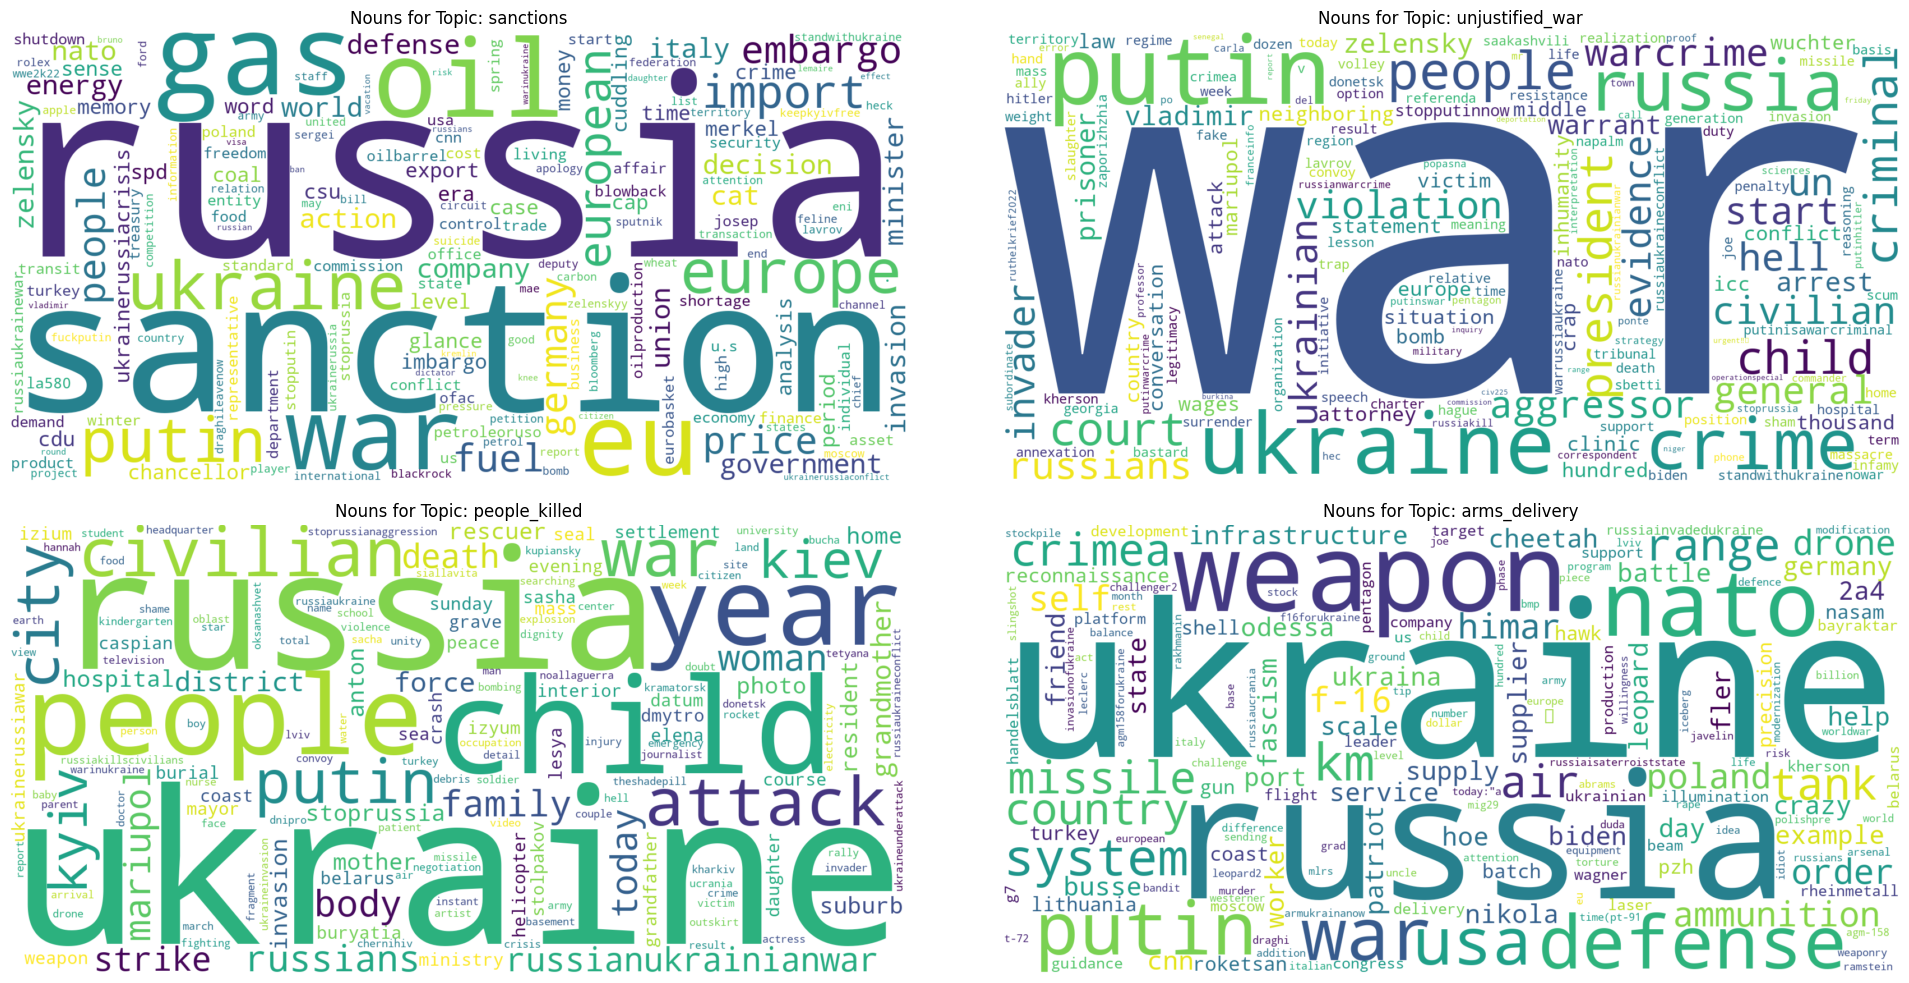

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 10]

fig, axis = plt.subplots(2, 2)

fig.tight_layout()

for ind, ax in enumerate(axis.reshape(-1)):

    wc = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        max_font_size=10000,
        max_words=200,
    )

    wc.generate_from_frequencies(topic_nouns_counter[topic_names[ind]])

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.title.set_text(f"Nouns for Topic: {topic_names[ind]}")
# plt.axis('off')
# plt.title(f"Nouns for Topic: {topic_names[0]}")
plt.show()

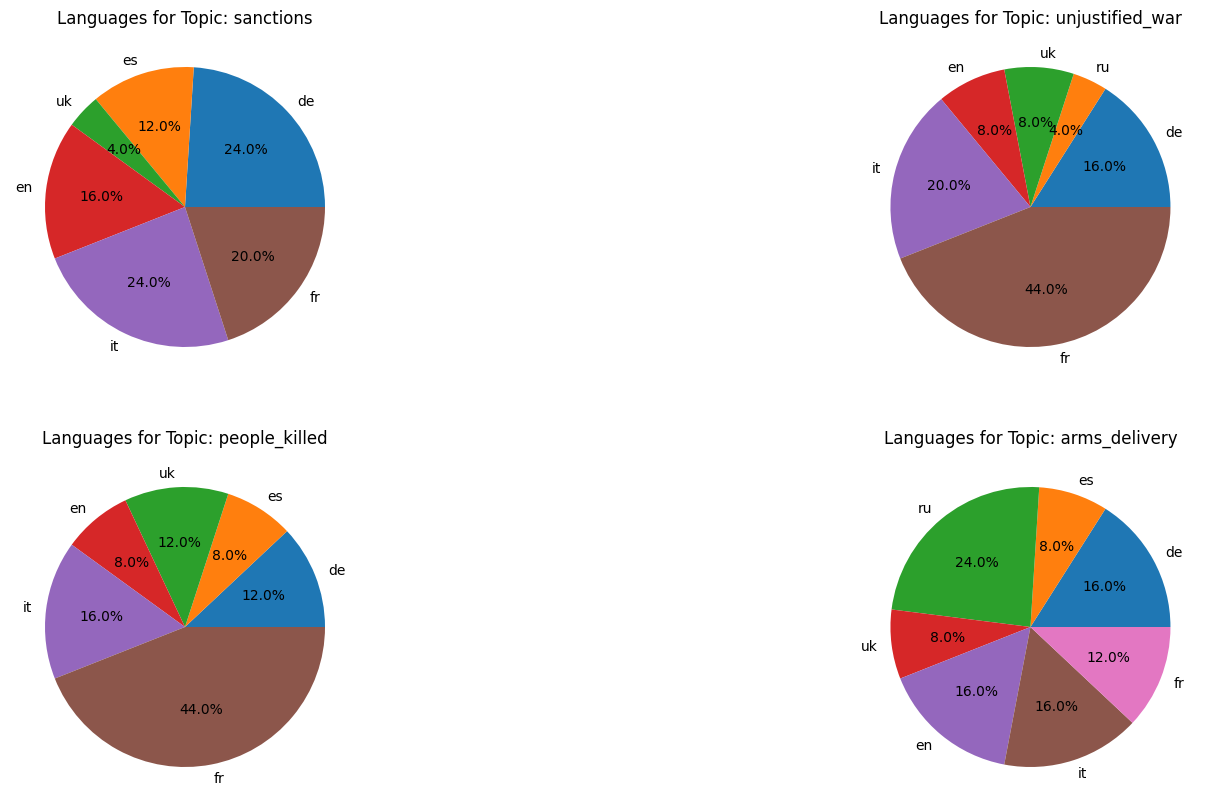

In [39]:
import numpy as np

fig, axis = plt.subplots(2, 2)

fig.tight_layout()


for ind, ax in enumerate(axis.reshape(-1)):

    df_lang = df.query(f"topics=='{topic_names[ind]}'")
    languages = df_lang["lang"].unique()
    language_counts = [df_lang.query(f"lang=='{la}'").shape[0] for la in languages]
    language_freq = np.array(
        [la_co / sum(language_counts) for la_co in language_counts]
    )
    freqs = language_freq

    ax.pie(freqs, labels=languages, autopct="%1.1f%%")
    ax.title.set_text(f"Languages for Topic: {topic_names[ind]}")
plt.show()

## Latent Dirichlet Allocation
Calculate Topics with LDA on translated tweets

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import stop_words
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

count_vect = CountVectorizer(
    ngram_range=(1, 1),
    min_df=1,
    max_df=1.0,
    lowercase=False,
    stop_words=list(stop_words.STOP_WORDS),
)


X_tf = count_vect.fit_transform(df["translated_lemmas"].str.join(" "))


num_topics = 4

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10)

lda_topic_list = []
for _ in tqdm(range(1000)):
    lda.fit(X_tf)

    lda_topics = [lda.transform(x).argmax() for x in X_tf]
    lda_topic_list.append(lda_topics)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


In [45]:
get_best_topics(lda_topic_list, df["topics_numbers"].to_list())

KeyError: 'topics_numbers'

In [27]:
map_to_numbers(df["topics_numbers"].to_list(), lda_topic_list[0])

NameError: name 'map_to_numbers' is not defined

## Kmeans Clustering

In [158]:
df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text',
       'translated', 'tweetcreatedts', 'tweetid', 'week',
       'cleaned_text_translated', 'cleaned_text', 'lemmas', 'adjs_verbs',
       'nouns', 'entities', 'emojis', 'translated_lemmas',
       'translated_adjs_verbs', 'translated_nouns', 'translated_entities',
       'translated_emojis', 'lang', 'topics', 'Unnamed: 21', 'topics_robin',
       'kmeans_cleaned_text_topics', 'kmeans_lemmas_topics', 'nouns_topics',
       'embeddings_lemmas', 'cleaned_text_embeddings', 'embeddings_nouns',
       'topics_numbers', 'lda_topics', 'lda_nouns_adjs_verbs_topics',
       'lda_lemmas_topics', 'stop_word_removed_lemmas',
       'dirty_text_embeddings', 'stop_word_removed_lemmas_embeddings',
       'cleaned_text_translated_embeddings'],
      dtype='object')

In [148]:
from tqdm import tqdm
from bertopic import BERTopic
import numpy as np
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=4)
topic_model = BERTopic(hdbscan_model=cluster_model)

kmeans_topics_list = []

for _ in tqdm(range(100)):
    topics, probs = topic_model.fit_transform(
        df["text"].to_list(),
        embeddings=np.stack(df["embeddings_lemmas"].to_list(), axis=0),
    )
    kmeans_topics_list.append(topics)

100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


## HDBSCAN Clustering

In [243]:
from tqdm import tqdm
from bertopic import BERTopic
import numpy as np
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    max_cluster_size=40,
    min_samples=3,
)

topic_model = BERTopic(nr_topics=5, hdbscan_model=hdbscan_model)

hdbs_topics_list = []


while len(hdbs_topics_list) < 100:

    topics, probs = topic_model.fit_transform(
        df["text"].to_list(),
        embeddings=np.stack(df["dirty_text_embeddings"].to_list(), axis=0),
    )

    if len(set(topics)) == 5 and (np.array(topics) == -1).sum() < 15:
        print(len(hdbs_topics_list))
        hdbs_topics_list.append(topics)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [322]:
len(hdbs_topics_list)

100

In [328]:
a = [
    map_to_numbers(df["topics_numbers"].to_list(), topic) for topic in hdbs_topics_list
]
a.index(max(a))

0

In [46]:
df["topics_numbers"]

KeyError: 'topics_numbers'

In [329]:
hdbs_topics_list

[[1,
  3,
  0,
  1,
  1,
  2,
  3,
  2,
  1,
  1,
  0,
  3,
  1,
  -1,
  3,
  2,
  3,
  1,
  1,
  0,
  3,
  1,
  0,
  3,
  3,
  3,
  3,
  3,
  2,
  3,
  3,
  0,
  3,
  0,
  1,
  0,
  -1,
  -1,
  -1,
  1,
  3,
  -1,
  3,
  3,
  1,
  0,
  -1,
  -1,
  3,
  0,
  3,
  1,
  3,
  1,
  2,
  1,
  0,
  1,
  1,
  2,
  1,
  -1,
  2,
  1,
  3,
  0,
  -1,
  2,
  3,
  3,
  3,
  0,
  0,
  0,
  0,
  2,
  0,
  2,
  3,
  0,
  2,
  0,
  -1,
  3,
  3,
  2,
  0,
  -1,
  3,
  0,
  3,
  1,
  3,
  1,
  1,
  0,
  3,
  3,
  3,
  -1],
 [1,
  2,
  0,
  1,
  1,
  -1,
  2,
  3,
  1,
  1,
  0,
  2,
  1,
  -1,
  2,
  3,
  2,
  1,
  1,
  0,
  2,
  1,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  2,
  0,
  1,
  0,
  -1,
  -1,
  2,
  1,
  2,
  -1,
  2,
  2,
  1,
  0,
  1,
  -1,
  2,
  0,
  2,
  1,
  2,
  1,
  3,
  1,
  0,
  1,
  1,
  3,
  1,
  -1,
  3,
  1,
  2,
  0,
  3,
  3,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  3,
  0,
  3,
  2,
  0,
  3,
  0,
  -1,
  2,
  2,
  3,
  0,
  3,
  2,
  0,
  2,
  1,
  2,
  1,
  1,
  0,

In [189]:
a[15]

73

In [190]:
df["hdbscan_cleaned_text_topics"] = hdbs_topics_list[15]

In [44]:
import itertools


def map_to_numbers(topic_a: list[int], topic_b: list[int]):
    permutations = [
        {-1: -1, **{key: val for key, val in zip((0, 1, 2, 3), perm)}}
        for perm in list(itertools.permutations([0, 1, 2, 3]))
    ]

    dist = [
        (np.array(topic_a) == np.array([perm[x] for x in topic_b])).sum()
        for perm in permutations
    ]
    permutation = permutations[dist.index(max(dist))]

    return (
        np.array(topic_a) == np.array([permutation[x] for x in topic_b])
    ).sum(), permutation


def get_best_topics(topics: list[list[int], topic : list[int]]) -> list[int]:

    distances = [map_to_numbers(top, topic)[0] for top in topics]
    best_topic = distances[distances.index(max(distances))]

    mapped_topic, dist = map_to_numbers(topic, best_topic)

    print(dist)

    return mapped_topic

In [191]:
col_to_map = "hdbscan_cleaned_text_topics"
permutations = [
    {-1: -1, **{key: val for key, val in zip((0, 1, 2, 3), perm)}}
    for perm in list(itertools.permutations([0, 1, 2, 3]))
]
dist = [
    (df["topics_numbers"] == df[col_to_map].apply(lambda x: perm[x])).sum()
    for perm in permutations
]

permutation = permutations[dist.index(max(dist))]
df[col_to_map] = df[col_to_map].apply(lambda x: permutation[x])
print((df["topics_numbers"] == df[col_to_map]).sum())

73


In [6]:
def unfold_on_columns(
    df: pd.DataFrame,
    cols_to_unfold: list[str],
    new_col_name: str = "combined",
    sep_col_name: str = "sep",
) -> pd.DataFrame:
    for col in cols_to_unfold:
        if not col in df.columns:
            raise KeyError(f"Col {col} not in columns of df.")

    others_cols = [x for x in df.columns if not x in cols_to_unfold]

    list_of_dfs = []
    for col in cols_to_unfold:
        df_sel = df[others_cols]
        df_sel[new_col_name] = df[col]
        df_sel[sep_col_name] = str(col)
        list_of_dfs.append(df_sel)

    return pd.concat(list_of_dfs)

In [77]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text', 'translated',
       'tweetcreatedts', 'tweetid', 'week', 'cleaned_text_translated',
       'cleaned_text', 'lemmas', 'adjs_verbs', 'nouns', 'entities', 'emojis',
       'translated_lemmas', 'translated_adjs_verbs', 'translated_nouns',
       'translated_entities', 'translated_emojis', 'lang', 'topics',
       'Unnamed: 21', 'topics_robin', 'embeddings_lemmas', 'embeddings_nouns',
       'cleaned_text_embeddings', 'kmeans_cleaned_text_topics',
       'kmeans_lemmas_topics', 'nouns_topics'],
      dtype='object')

In [50]:
df[]

0     1
1     1
2     2
3     0
4     0
     ..
95    2
96    1
97    1
98    1
99    1
Name: kmeans_cleaned_text_topics, Length: 100, dtype: int64

In [61]:
(df["topics_numbers"] == df["kmeans_cleaned_text_topics"]).sum()

46

In [134]:
import itertools

permuations = [
    {key: val for key, val in zip((0, 1, 2, 3), perm)}
    for perm in list(itertools.permutations([0, 1, 2, 3]))
]
dist = [
    (
        df["topics_numbers"]
        == df["kmeans_cleaned_text_topics"].apply(lambda x: perm[x])
    ).sum()
    for perm in permuations
]
dist.index(max(dist))

19

In [221]:
df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text',
       'translated', 'tweetcreatedts', 'tweetid', 'week',
       'cleaned_text_translated', 'cleaned_text', 'lemmas', 'adjs_verbs',
       'nouns', 'entities', 'emojis', 'translated_lemmas',
       'translated_adjs_verbs', 'translated_nouns', 'translated_entities',
       'translated_emojis', 'lang', 'topics', 'Unnamed: 21', 'topics_robin',
       'kmeans_cleaned_text_topics', 'kmeans_lemmas_topics', 'nouns_topics',
       'embeddings_lemmas', 'cleaned_text_embeddings', 'embeddings_nouns',
       'topics_numbers', 'lda_topics', 'lda_nouns_adjs_verbs_topics',
       'lda_lemmas_topics', 'stop_word_removed_lemmas',
       'dirty_text_embeddings', 'stop_word_removed_lemmas_embeddings',
       'cleaned_text_translated_embeddings', 'hdbscan_lemmas_topics',
       'hdbscan_cleaned_text_topics'],
      dtype='object')

In [236]:
topic_cols = [
    "topics_numbers",
    "lda_lemmas_topics",
    "lda_nouns_adjs_verbs_topics",
    "kmeans_cleaned_text_topics",
    "kmeans_lemmas_topics",
    "hdbscan_lemmas_topics",
    "hdbscan_cleaned_text_topics",
]


df_min = df[
    [
        *topic_cols,
        "embeddings_lemmas",
        "stop_word_removed_lemmas_embeddings",
        "cleaned_text_translated",
        "lang",
    ]
]


for top in topic_cols:
    df_min[top] = df_min[top].apply(str)
    df_min[f"{top}_score"] = (df_min[top] == df_min["topics_numbers"]).sum()
df_plot = unfold_on_columns(
    df_min,
    cols_to_unfold=[*topic_cols],
)

df_plot_unf = unfold_on_columns(
    df_plot,
    cols_to_unfold=["embeddings_lemmas", "stop_word_removed_lemmas_embeddings"],
    new_col_name="embeddings",
    sep_col_name="embeddings_space",
)

In [280]:
df_plot_unf

,cleaned_text_translated,lang,topics_numbers_score,lda_lemmas_topics_score,lda_nouns_adjs_verbs_topics_score,kmeans_cleaned_text_topics_score,kmeans_lemmas_topics_score,hdbscan_lemmas_topics_score,hdbscan_cleaned_text_topics_score,combined,sep,embeddings,embeddings_space
0,ukrainewar: the eu sanctions against russia...,de,100,52,49,63,79,72,73,0,topics_numbers,"[-0.009074805, -0.0574717, -0.030188987, -0.06...",embeddings_lemmas
1,"vogt-wuchter: ""we are shocked by the war in uk...",de,100,52,49,63,79,72,73,1,topics_numbers,"[0.024267722, -0.016830716, -0.0496836, -0.048...",embeddings_lemmas
2,the interior ministry of ukraine reported on ...,de,100,52,49,63,79,72,73,2,topics_numbers,"[-0.00031765725, -0.036075648, -0.040189527, -...",embeddings_lemmas
3,chancellor stop imports from russia immediatel...,de,100,52,49,63,79,72,73,0,topics_numbers,"[-0.0025235536, -0.023199191, -0.05079851, -0....",embeddings_lemmas
4,ukraine everyone complains about high gas pric...,de,100,52,49,63,79,72,73,0,topics_numbers,"[-0.006271366, -0.026778685, -0.07327518, -0.0...",embeddings_lemmas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ukraine: at least two civilians killed and 10 ...,fr,100,52,49,63,79,72,73,2,hdbscan_cleaned_text_topics,"[0.020054473, -0.034196053, -0.046252903, -0.0...",stop_word_removed_lemmas_embeddings
96,alert the international criminal court issues ...,fr,100,52,49,63,79,72,73,0,hdbscan_cleaned_text_topics,"[0.014442559, -0.047339212, -0.017482815, -0.0...",stop_word_removed_lemmas_embeddings
97,🔴 ukrainerussianwar urgent‼️ the internationa...,fr,100,52,49,63,79,72,73,0,hdbscan_cleaned_text_topics,"[0.04936054, -0.050346065, 0.010020273, -0.026...",stop_word_removed_lemmas_embeddings
98,war in ukraine: russia committed wide range ...,fr,100,52,49,63,79,72,73,0,hdbscan_cleaned_text_topics,"[0.037067827, -0.033046637, -0.045385316, -0.0...",stop_word_removed_lemmas_embeddings


In [261]:
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [30, 10]

min_embeddings = PCA(n_components=2).fit_transform(
    np.array(df_plot_unf["embeddings"].to_list())
)
x = min_embeddings[:, 0]
y = min_embeddings[:, 1]

x_axis_range = [x.min() - 1, x.max() + 1]
y_axis_range = [y.min() - 1, y.max() + 1]


fig = px.scatter(
    df_plot_unf,
    y=y,
    x=x,
    range_x=x_axis_range,
    range_y=y_axis_range,
    hover_data=["cleaned_text_translated", "lang"],
    color="combined",
    # facet_col="sep",
    # facet_row="embeddings_space",
    # title="Labse Cleaned Text Embeddings: K-Means on lemmas vs K-Means on cleaned vs Handpicked ",
)
fig.update_traces(marker_size=10)
fig.update_layout(showlegend=False)
fig.update_layout(
    autosize=False,
    width=1600,
    height=800,
)


# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
def col_titles(a):
    if "sep" in a.text:
        text = f"{a.text.split('=')[-1].replace('_topics', '')}  score: {df_plot_unf[f'''{a.text.split('=')[-1]}_score'''].mean()}"

        return a.update(text=text)
    else:
        return a.update(text=a.text.split("=")[-1])


fig.for_each_annotation(col_titles)
fig.show()

In [285]:
from src.metrics import calculate_metrics_weighted_sorted


def get_metrics(
    df: pd.DataFrame, topics: list[int], eval_space: str
) -> dict[str, float]:
    topic_series = pd.Series(topics)
    topic_series = topic_series[topic_series != -1]

    return {
        "outliers": (pd.Series(topics) == -1).sum() / 100,
        **calculate_metrics_weighted_sorted(df, topics, eval_space),
        "accordings": (df["topics_numbers"] == pd.Series(topics)).sum() / 100,
    }

In [302]:
def get_metric_plot(df, topics_col, eval_space):
    topics_col = "topics_numbers"
    eval_space = "translated_nouns_adjs_verbs"

    l = []
    for name, score in get_metrics(df, df[topics_col].to_list(), eval_space).items():
        l.append({"score": score, "name": name})

    fig = px.bar(pd.DataFrame(l), x="name", y="score")
    return fig


get_metric_plot(df, "topics_numbers", "translated_nouns_adjs_verbs").show()

In [316]:
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


embedding_col = "cleaned_text_embeddings"
topics_col = "hdbscan_cleaned_text_topics"
# df[topic_cols] = df[topic_cols].apply(lambda x: str(x))

plt.rcParams["figure.figsize"] = [30, 10]

min_embeddings = PCA(n_components=2).fit_transform(
    np.array(df[embedding_col].to_list())
)
x = min_embeddings[:, 0]
y = min_embeddings[:, 1]

x_axis_range = [x.min() - 1, x.max() + 1]
y_axis_range = [y.min() - 1, y.max() + 1]


fig = px.scatter(
    df,
    y=y,
    x=x,
    range_x=x_axis_range,
    range_y=y_axis_range,
    hover_data=["cleaned_text_translated", "lang"],
    color=topic_cols,
    # facet_col="sep",
    # facet_row="embeddings_space",
    # title="Labse Cleaned Text Embeddings: K-Means on lemmas vs K-Means on cleaned vs Handpicked ",
)

fig.show()

ValueError: All arguments should have the same length. The length of argument `color` is 7, whereas the length of  previously-processed arguments ['x', 'y', 'cleaned_text_translated', 'lang'] is 100

In [253]:
df["translated_nouns_adjs_verbs"] = df["translated_adjs_verbs"] + df["translated_nouns"]

In [305]:
df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text',
       'translated', 'tweetcreatedts', 'tweetid', 'week',
       'cleaned_text_translated', 'cleaned_text', 'lemmas', 'adjs_verbs',
       'nouns', 'entities', 'emojis', 'translated_lemmas',
       'translated_adjs_verbs', 'translated_nouns', 'translated_entities',
       'translated_emojis', 'lang', 'topics', 'Unnamed: 21', 'topics_robin',
       'kmeans_cleaned_text_topics', 'kmeans_lemmas_topics', 'nouns_topics',
       'embeddings_lemmas', 'cleaned_text_embeddings', 'embeddings_nouns',
       'topics_numbers', 'lda_topics', 'lda_nouns_adjs_verbs_topics',
       'lda_lemmas_topics', 'stop_word_removed_lemmas',
       'dirty_text_embeddings', 'stop_word_removed_lemmas_embeddings',
       'cleaned_text_translated_embeddings', 'hdbscan_lemmas_topics',
       'hdbscan_cleaned_text_topics', 'translated_nouns_adjs_verbs'],
      dtype='object')

In [279]:
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

from plotly.offline import iplot

df1 = pd.DataFrame([{"x": x, "y": y} for x, y in zip(range(100), range(100))])
df2 = pd.DataFrame([{"x": x, "y": y} for x, y in zip(range(100), range(100))])
figures = [
    px.line(df1),
    px.scatter(
        df_plot_unf,
        y=y,
        x=x,
        range_x=x_axis_range,
        range_y=y_axis_range,
        hover_data=["cleaned_text_translated", "lang"],
        color="combined",
        # facet_col="sep",
        # facet_row="embeddings_space",
        title="Labse Cleaned Text Embeddings: K-Means on lemmas vs K-Means on cleaned vs Handpicked ",
    ),
]

fig = make_subplots(rows=len(figures), cols=1, subplot_titles=["some", "else"])

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i + 1, col=1)

fig.update_layout(showlegend=False)
iplot(fig)

In [276]:
fig.get_subplot(row=2, col=1).



SubplotXY(xaxis=layout.XAxis({
    'anchor': 'y2', 'domain': [0.0, 1.0]
}), yaxis=layout.YAxis({
    'anchor': 'x2', 'domain': [0.0, 0.425]
}))